# Price Per Unit - Rescaling Methods Comparison

## Overview

This notebook implements and compares three rescaling methods for the **Price Per Unit** attribute:
1. **Min-Max Normalization** (RECOMMENDED)
2. **Z-Score Standardization**
3. **Robust Scaling**

## Source Dataset

**Input:** `handle_missing_data/output_data/4_discount_applied/final_cleaned_dataset.csv`
- 11,971 rows (after missing data handling)
- Price Per Unit reconstructed from Total Spent ÷ Quantity
- All missing values resolved

## Price Per Unit Characteristics

- **Type:** Continuous currency data
- **Range:** Typically $1-$100
- **Distribution:** Varies by item category
- **Outliers:** Present but handled during reconstruction
- **Recommendation:** Min-Max Normalization (natural bounds, interpretable)

---

## Step 1: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Configuration
INPUT_CSV = Path('../../../handle_missing_data/output_data/4_discount_applied/final_cleaned_dataset.csv')
OUTPUT_DIR = Path('../../output_data/price_per_unit')
PRICE_PER_UNIT_COLUMN = 'Price Per Unit'

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Input file: {INPUT_CSV}")
print(f"Output directory: {OUTPUT_DIR}")

Input file: ../../../handle_missing_data/output_data/4_discount_applied/final_cleaned_dataset.csv
Output directory: ../../output_data/price_per_unit


In [2]:
# Load the cleaned dataset
df = pd.read_csv(INPUT_CSV)

df.head()

,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_1002182,CUST_01,Food,Item_5_FOOD,11.0,5.0,55.0,Digital Wallet,In-store,2024-10-08,True
1,TXN_1003865,CUST_15,Furniture,Item_2_FUR,6.5,5.0,32.5,Cash,Online,2022-03-12,False
2,TXN_1003940,CUST_06,Furniture,Item_5_FUR,11.0,9.0,99.0,Digital Wallet,Online,2022-04-22,False
3,TXN_1004091,CUST_04,Food,Item_25_FOOD,41.0,3.0,123.0,Cash,In-store,2023-11-09,False
4,TXN_1004124,CUST_08,Computers and electric accessories,Item_7_CEA,14.0,5.0,70.0,Credit Card,In-store,2022-03-02,Unknown


## Step 2: Exploratory Data Analysis - Price Per Unit

In [3]:
# Basic statistics
print("=" * 80)
print("PRICE PER UNIT - Descriptive Statistics")
print("=" * 80)
print(f"\n{df[PRICE_PER_UNIT_COLUMN].describe()}")

# Additional statistics
print(f"\nMissing values: {df[PRICE_PER_UNIT_COLUMN].isna().sum()}")
print(f"Unique values: {df[PRICE_PER_UNIT_COLUMN].nunique()}")
print(f"\nPrice range: ${df[PRICE_PER_UNIT_COLUMN].min():.2f} - ${df[PRICE_PER_UNIT_COLUMN].max():.2f}")

PRICE PER UNIT - Descriptive Statistics

count    11971.000000
mean        23.360872
std         10.741889
min          5.000000
25%         14.000000
50%         23.000000
75%         33.500000
max         41.000000
Name: Price Per Unit, dtype: float64

Missing values: 0
Unique values: 25

Price range: $5.00 - $41.00


In [4]:
# Outlier detection using IQR method
Q1 = df[PRICE_PER_UNIT_COLUMN].quantile(0.25)
Q3 = df[PRICE_PER_UNIT_COLUMN].quantile(0.75)
IQR = Q3 - Q1

lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

outliers = df[(df[PRICE_PER_UNIT_COLUMN] < lower_fence) | (df[PRICE_PER_UNIT_COLUMN] > upper_fence)]

print("=" * 80)
print("OUTLIER DETECTION (IQR Method)")
print("=" * 80)
print(f"Q1 (25th percentile): ${Q1:.2f}")
print(f"Q3 (75th percentile): ${Q3:.2f}")
print(f"IQR: ${IQR:.2f}")
print(f"Lower fence: ${lower_fence:.2f}")
print(f"Upper fence: ${upper_fence:.2f}")
print(f"\nNumber of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

if len(outliers) > 0:
    print(f"Outlier price range: ${outliers[PRICE_PER_UNIT_COLUMN].min():.2f} to ${outliers[PRICE_PER_UNIT_COLUMN].max():.2f}")
    print(f"\nNote: Outliers were handled during Price Per Unit reconstruction (Total Spent ÷ Quantity)")

OUTLIER DETECTION (IQR Method)
Q1 (25th percentile): $14.00
Q3 (75th percentile): $33.50
IQR: $19.50
Lower fence: $-15.25
Upper fence: $62.75

Number of outliers: 0 (0.00%)


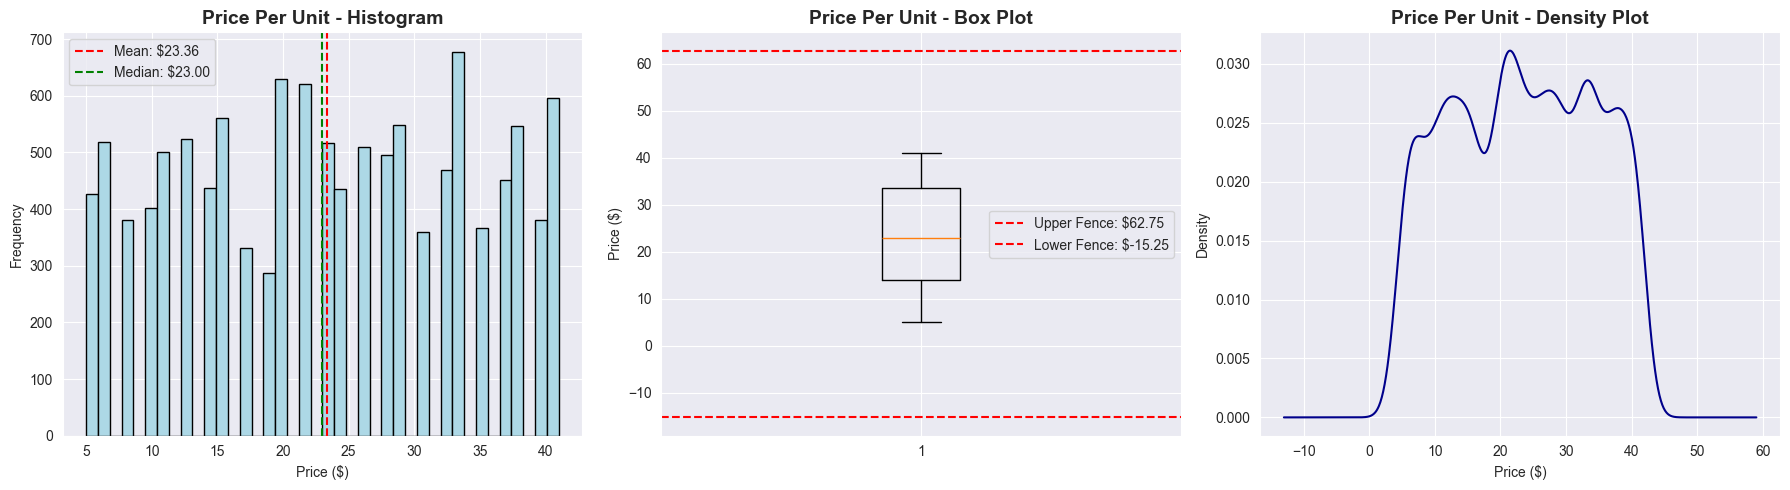


Distribution Analysis:
- Skewness: -0.0333
  → Approximately symmetric distribution
- Natural bounds: Prices > $0 with practical upper limit
- Outliers already handled during reconstruction phase


In [5]:
# Visualize original distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df[PRICE_PER_UNIT_COLUMN], bins=40, color='lightblue', edgecolor='black')
axes[0].set_title('Price Per Unit - Histogram', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df[PRICE_PER_UNIT_COLUMN].mean(), color='red', linestyle='--', 
                label=f'Mean: ${df[PRICE_PER_UNIT_COLUMN].mean():.2f}')
axes[0].axvline(df[PRICE_PER_UNIT_COLUMN].median(), color='green', linestyle='--', 
                label=f'Median: ${df[PRICE_PER_UNIT_COLUMN].median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df[PRICE_PER_UNIT_COLUMN], vert=True)
axes[1].set_title('Price Per Unit - Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price ($)')
axes[1].axhline(upper_fence, color='red', linestyle='--', label=f'Upper Fence: ${upper_fence:.2f}')
axes[1].axhline(lower_fence, color='red', linestyle='--', label=f'Lower Fence: ${lower_fence:.2f}')
axes[1].legend()

# Distribution plot
df[PRICE_PER_UNIT_COLUMN].plot(kind='kde', ax=axes[2], color='darkblue')
axes[2].set_title('Price Per Unit - Density Plot', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Price ($)')
axes[2].set_ylabel('Density')

plt.tight_layout()
plt.show()

print("\nDistribution Analysis:")
skewness = df[PRICE_PER_UNIT_COLUMN].skew()
print(f"- Skewness: {skewness:.4f}")
if abs(skewness) < 0.5:
    print("  → Approximately symmetric distribution")
elif skewness > 0:
    print("  → Right-skewed distribution (some high-priced items)")
else:
    print("  → Left-skewed distribution")
print(f"- Natural bounds: Prices > $0 with practical upper limit")
print(f"- Outliers already handled during reconstruction phase")

## Step 3: Apply Rescaling Methods

We will apply all three methods and compare them.

### Method 1: Min-Max Normalization (RECOMMENDED)

In [6]:
# Min-Max Normalization
min_max_scaler = MinMaxScaler()
df['PricePerUnit_Normalized'] = min_max_scaler.fit_transform(df[[PRICE_PER_UNIT_COLUMN]])

print("=" * 80)
print("MIN-MAX NORMALIZATION (RECOMMENDED)")
print("=" * 80)
print(f"Formula: (X - X_min) / (X_max - X_min)")
print(f"Range: [0, 1]")
print(f"\nOriginal range: [${df[PRICE_PER_UNIT_COLUMN].min():.2f}, ${df[PRICE_PER_UNIT_COLUMN].max():.2f}]")
print(f"Scaled range: [{df['PricePerUnit_Normalized'].min():.6f}, {df['PricePerUnit_Normalized'].max():.6f}]")
print(f"\nInterpretation:")
print(f"  - 0.0 = Cheapest item (${df[PRICE_PER_UNIT_COLUMN].min():.2f})")
print(f"  - 1.0 = Most expensive item (${df[PRICE_PER_UNIT_COLUMN].max():.2f})")
print(f"  - 0.5 ≈ Mid-range price (${(df[PRICE_PER_UNIT_COLUMN].min() + df[PRICE_PER_UNIT_COLUMN].max())/2:.2f})")
print(f"\nStatistics:")
print(df['PricePerUnit_Normalized'].describe())

# Show examples
print(f"\nExample transformations:")
print(df[[PRICE_PER_UNIT_COLUMN, 'PricePerUnit_Normalized']].head(10))

MIN-MAX NORMALIZATION (RECOMMENDED)
Formula: (X - X_min) / (X_max - X_min)
Range: [0, 1]

Original range: [$5.00, $41.00]
Scaled range: [0.000000, 1.000000]

Interpretation:
  - 0.0 = Cheapest item ($5.00)
  - 1.0 = Most expensive item ($41.00)
  - 0.5 ≈ Mid-range price ($23.00)

Statistics:
count    11971.000000
mean         0.510024
std          0.298386
min          0.000000
25%          0.250000
50%          0.500000
75%          0.791667
max          1.000000
Name: PricePerUnit_Normalized, dtype: float64

Example transformations:
   Price Per Unit  PricePerUnit_Normalized
0            11.0                 0.166667
1             6.5                 0.041667
2            11.0                 0.166667
3            41.0                 1.000000
4            14.0                 0.250000
5            41.0                 1.000000
6            21.5                 0.458333
7            15.5                 0.291667
8            29.0                 0.666667
9            18.5            

### Method 2: Z-Score Standardization

In [7]:
# Z-Score Standardization
standard_scaler = StandardScaler()
df['PricePerUnit_Standardized'] = standard_scaler.fit_transform(df[[PRICE_PER_UNIT_COLUMN]])

print("=" * 80)
print("Z-SCORE STANDARDIZATION")
print("=" * 80)
print(f"Formula: (X - μ) / σ")
print(f"Range: Unbounded (typically [-3, 3] for normal distribution)")
print(f"\nOriginal mean: ${df[PRICE_PER_UNIT_COLUMN].mean():.2f}")
print(f"Original std: ${df[PRICE_PER_UNIT_COLUMN].std():.2f}")
print(f"\nScaled mean: {df['PricePerUnit_Standardized'].mean():.6f}")
print(f"Scaled std: {df['PricePerUnit_Standardized'].std():.6f}")
print(f"\nStatistics:")
print(df['PricePerUnit_Standardized'].describe())

# Show examples
print(f"\nExample transformations:")
print(df[[PRICE_PER_UNIT_COLUMN, 'PricePerUnit_Standardized']].head(10))

Z-SCORE STANDARDIZATION
Formula: (X - μ) / σ
Range: Unbounded (typically [-3, 3] for normal distribution)

Original mean: $23.36
Original std: $10.74

Scaled mean: -0.000000
Scaled std: 1.000042

Statistics:
count    1.197100e+04
mean    -9.793631e-17
std      1.000042e+00
min     -1.709349e+00
25%     -8.714727e-01
50%     -3.359625e-02
75%      9.439263e-01
max      1.642157e+00
Name: PricePerUnit_Standardized, dtype: float64

Example transformations:
   Price Per Unit  PricePerUnit_Standardized
0            11.0                  -1.150765
1             6.5                  -1.569703
2            11.0                  -1.150765
3            41.0                   1.642157
4            14.0                  -0.871473
5            41.0                   1.642157
6            21.5                  -0.173242
7            15.5                  -0.731827
8            29.0                   0.524988
9            18.5                  -0.452534


### Method 3: Robust Scaling

In [8]:
# Robust Scaling
robust_scaler = RobustScaler()
df['PricePerUnit_Robust'] = robust_scaler.fit_transform(df[[PRICE_PER_UNIT_COLUMN]])

print("=" * 80)
print("ROBUST SCALING")
print("=" * 80)
print(f"Formula: (X - median) / IQR")
print(f"Range: Unbounded (concentrated around 0)")
print(f"\nOriginal median: ${df[PRICE_PER_UNIT_COLUMN].median():.2f}")
print(f"Original IQR: ${IQR:.2f}")
print(f"\nScaled median: {df['PricePerUnit_Robust'].median():.6f}")
print(f"Scaled IQR: {df['PricePerUnit_Robust'].quantile(0.75) - df['PricePerUnit_Robust'].quantile(0.25):.6f}")
print(f"\nStatistics:")
print(df['PricePerUnit_Robust'].describe())

# Show examples
print(f"\nExample transformations:")
print(df[[PRICE_PER_UNIT_COLUMN, 'PricePerUnit_Robust']].head(10))

ROBUST SCALING
Formula: (X - median) / IQR
Range: Unbounded (concentrated around 0)

Original median: $23.00
Original IQR: $19.50

Scaled median: 0.000000
Scaled IQR: 1.000000

Statistics:
count    11971.000000
mean         0.018506
std          0.550866
min         -0.923077
25%         -0.461538
50%          0.000000
75%          0.538462
max          0.923077
Name: PricePerUnit_Robust, dtype: float64

Example transformations:
   Price Per Unit  PricePerUnit_Robust
0            11.0            -0.615385
1             6.5            -0.846154
2            11.0            -0.615385
3            41.0             0.923077
4            14.0            -0.461538
5            41.0             0.923077
6            21.5            -0.076923
7            15.5            -0.384615
8            29.0             0.307692
9            18.5            -0.230769


## Step 4: Compare All Methods

In [9]:
# Comparison table
comparison = pd.DataFrame({
    'Method': ['Original', 'Normalization (RECOMMENDED)', 'Standardization', 'Robust Scaling'],
    'Column': [PRICE_PER_UNIT_COLUMN, 'PricePerUnit_Normalized', 'PricePerUnit_Standardized', 'PricePerUnit_Robust'],
    'Min': [df[PRICE_PER_UNIT_COLUMN].min(), df['PricePerUnit_Normalized'].min(), 
            df['PricePerUnit_Standardized'].min(), df['PricePerUnit_Robust'].min()],
    'Max': [df[PRICE_PER_UNIT_COLUMN].max(), df['PricePerUnit_Normalized'].max(), 
            df['PricePerUnit_Standardized'].max(), df['PricePerUnit_Robust'].max()],
    'Mean': [df[PRICE_PER_UNIT_COLUMN].mean(), df['PricePerUnit_Normalized'].mean(), 
             df['PricePerUnit_Standardized'].mean(), df['PricePerUnit_Robust'].mean()],
    'Median': [df[PRICE_PER_UNIT_COLUMN].median(), df['PricePerUnit_Normalized'].median(), 
               df['PricePerUnit_Standardized'].median(), df['PricePerUnit_Robust'].median()],
    'Std': [df[PRICE_PER_UNIT_COLUMN].std(), df['PricePerUnit_Normalized'].std(), 
            df['PricePerUnit_Standardized'].std(), df['PricePerUnit_Robust'].std()]
})

print("=" * 80)
print("COMPARISON OF ALL METHODS")
print("=" * 80)
print(comparison.to_string(index=False))
print("\n" + "=" * 80)

COMPARISON OF ALL METHODS
                     Method                    Column       Min       Max          Mean    Median       Std
                   Original            Price Per Unit  5.000000 41.000000  2.336087e+01 23.000000 10.741889
Normalization (RECOMMENDED)   PricePerUnit_Normalized  0.000000  1.000000  5.100242e-01  0.500000  0.298386
            Standardization PricePerUnit_Standardized -1.709349  1.642157 -9.793631e-17 -0.033596  1.000042
             Robust Scaling       PricePerUnit_Robust -0.923077  0.923077  1.850626e-02  0.000000  0.550866



/var/folders/_j/shvq8ngx12qd5tv9vzyty6mh0000gn/T/ipykernel_83781/2435727298.py:38: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.tight_layout()


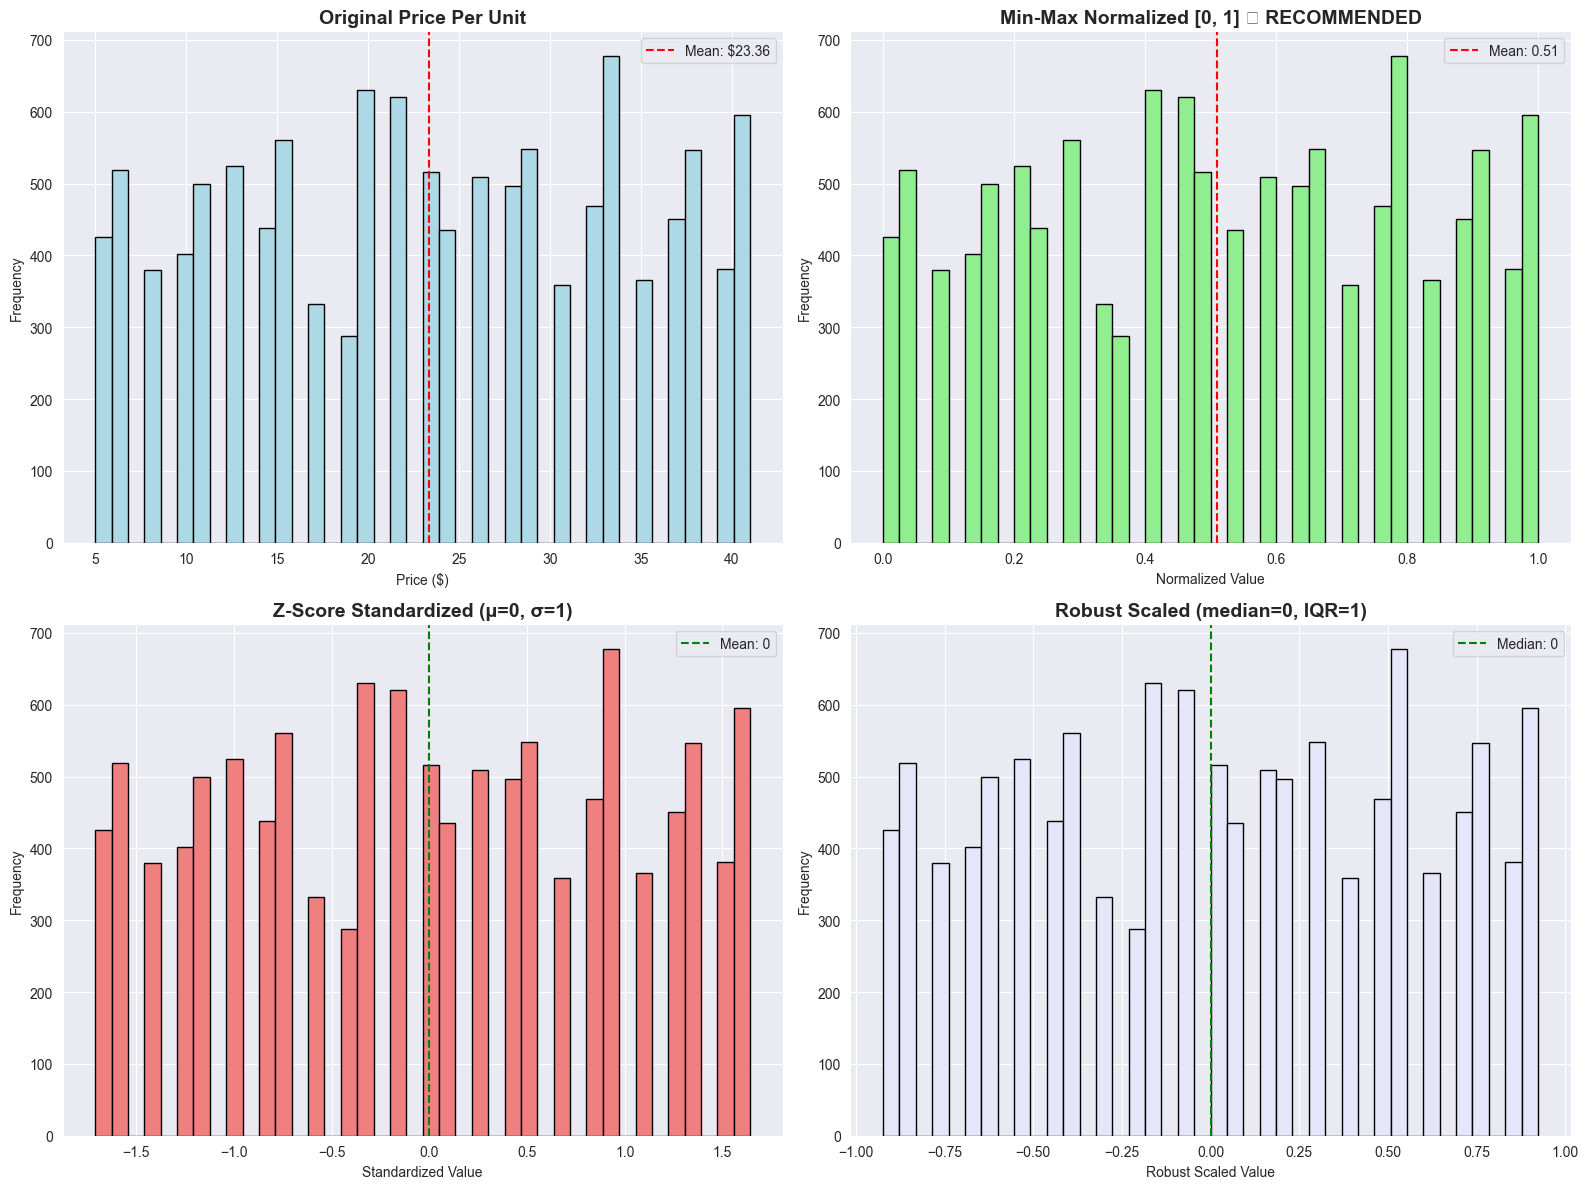

In [12]:
# Visualize all methods side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original
axes[0, 0].hist(df[PRICE_PER_UNIT_COLUMN], bins=40, color='lightblue', edgecolor='black')
axes[0, 0].set_title('Original Price Per Unit', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df[PRICE_PER_UNIT_COLUMN].mean(), color='red', linestyle='--', 
                   label=f'Mean: ${df[PRICE_PER_UNIT_COLUMN].mean():.2f}')
axes[0, 0].legend()

# Normalized (RECOMMENDED)
axes[0, 1].hist(df['PricePerUnit_Normalized'], bins=40, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Min-Max Normalized [0, 1] ⭐ RECOMMENDED', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Normalized Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['PricePerUnit_Normalized'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["PricePerUnit_Normalized"].mean():.2f}')
axes[0, 1].legend()

# Standardized
axes[1, 0].hist(df['PricePerUnit_Standardized'], bins=40, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Z-Score Standardized (μ=0, σ=1)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Standardized Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(0, color='green', linestyle='--', label='Mean: 0')
axes[1, 0].legend()

# Robust Scaled
axes[1, 1].hist(df['PricePerUnit_Robust'], bins=40, color='lavender', edgecolor='black')
axes[1, 1].set_title('Robust Scaled (median=0, IQR=1)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Robust Scaled Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(0, color='green', linestyle='--', label='Median: 0')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Step 5: Interpretability Analysis

In [13]:
# Analyze interpretability for Price Per Unit
print("=" * 80)
print("INTERPRETABILITY ANALYSIS")
print("=" * 80)

# Sample prices and their scaled values
sample_prices = [df[PRICE_PER_UNIT_COLUMN].min(), 
                 df[PRICE_PER_UNIT_COLUMN].quantile(0.25),
                 df[PRICE_PER_UNIT_COLUMN].median(),
                 df[PRICE_PER_UNIT_COLUMN].quantile(0.75),
                 df[PRICE_PER_UNIT_COLUMN].max()]

print("\nPrice → Normalized Value Mapping:")
print("-" * 80)
for price in sample_prices:
    normalized = (price - df[PRICE_PER_UNIT_COLUMN].min()) / (df[PRICE_PER_UNIT_COLUMN].max() - df[PRICE_PER_UNIT_COLUMN].min())
    print(f"${price:.2f} → {normalized:.4f}")

print("\n" + "=" * 80)
print("WHY MIN-MAX NORMALIZATION IS MOST INTERPRETABLE FOR PRICES:")
print("=" * 80)
print("\n1. BOUNDED RANGE [0, 1]:")
print("   ✓ 0.0 = Cheapest item in dataset")
print("   ✓ 1.0 = Most expensive item in dataset")
print("   ✓ 0.5 = Mid-range price")
print("   ✓ Clear, intuitive interpretation")

print("\n2. PRESERVES PRICE RELATIONSHIPS:")
print("   ✓ Linear transformation maintains relative differences")
print("   ✓ If item A costs 2× item B, ratio preserved in scaled values")

print("\n3. NATURAL FOR PRICES:")
print("   ✓ Prices have natural lower bound ($0)")
print("   ✓ Practical upper limit (luxury items)")
print("   ✓ Bounded nature suits Min-Max scaling")

print("\n4. ML ALGORITHM COMPATIBILITY:")
print("   ✓ Neural networks prefer [0, 1] inputs")
print("   ✓ Gradient descent converges faster with bounded features")
print("   ✓ No negative values (matches price semantics)")

INTERPRETABILITY ANALYSIS

Price → Normalized Value Mapping:
--------------------------------------------------------------------------------
$5.00 → 0.0000
$14.00 → 0.2500
$23.00 → 0.5000
$33.50 → 0.7917
$41.00 → 1.0000

WHY MIN-MAX NORMALIZATION IS MOST INTERPRETABLE FOR PRICES:

1. BOUNDED RANGE [0, 1]:
   ✓ 0.0 = Cheapest item in dataset
   ✓ 1.0 = Most expensive item in dataset
   ✓ 0.5 = Mid-range price
   ✓ Clear, intuitive interpretation

2. PRESERVES PRICE RELATIONSHIPS:
   ✓ Linear transformation maintains relative differences
   ✓ If item A costs 2× item B, ratio preserved in scaled values

3. NATURAL FOR PRICES:
   ✓ Prices have natural lower bound ($0)
   ✓ Practical upper limit (luxury items)
   ✓ Bounded nature suits Min-Max scaling

4. ML ALGORITHM COMPATIBILITY:
   ✓ Neural networks prefer [0, 1] inputs
   ✓ Gradient descent converges faster with bounded features
   ✓ No negative values (matches price semantics)


## Step 6: Final Recommendation & Justification

In [14]:
print("=" * 80)
print("FINAL RECOMMENDATION FOR PRICE PER UNIT")
print("=" * 80)

print("\n🏆 RECOMMENDED METHOD: MIN-MAX NORMALIZATION")
print("\nJustification:")
print("-" * 80)

print("\n1. DATA CHARACTERISTICS:")
print(f"   ✓ Natural bounds: Prices > $0 with practical upper limit")
print(f"   ✓ Range: ${df[PRICE_PER_UNIT_COLUMN].min():.2f} to ${df[PRICE_PER_UNIT_COLUMN].max():.2f}")
print(f"   ✓ Outliers already handled during reconstruction phase")
print(f"   ✓ Price Per Unit reconstructed via: Total Spent ÷ Quantity")

print("\n2. METHOD COMPARISON:")
print("   ✅ Min-Max Normalization (RECOMMENDED):")
print("      - Preserves price interpretability (0=cheapest, 1=most expensive)")
print("      - Bounded [0, 1] range suitable for prices")
print("      - Outliers managed in reconstruction step")
print("      - Linear relationships preserved")

print("\n   ⚠️  Z-Score Standardization:")
print("      - Unbounded range (can be negative)")
print("      - Loses price semantics (negative prices meaningless)")
print("      - Assumes normality (may not hold for all items)")

print("\n   ⚠️  Robust Scaling:")
print("      - Unbounded range")
print("      - Less interpretable for prices")
print("      - Overkill when outliers already handled")

print("\n3. PRACTICAL BENEFITS:")
print("   ✓ Easy to interpret: 0.7 = 70% of the way from cheapest to most expensive")
print("   ✓ Compatible with ML algorithms (neural nets, gradient descent)")
print("   ✓ Preserves relative price differences")
print("   ✓ No negative values (semantically correct for prices)")
print("   ✓ Bounded range prevents extreme scaled values")

print("\n4. VALIDATION AGAINST TOTAL SPENT:")
# Check correlation with Total Spent
corr_original = df[PRICE_PER_UNIT_COLUMN].corr(df['Total Spent'])
corr_normalized = df['PricePerUnit_Normalized'].corr(df['Total Spent'])
print(f"   ✓ Original Price ↔ Total Spent correlation: {corr_original:.4f}")
print(f"   ✓ Normalized Price ↔ Total Spent correlation: {corr_normalized:.4f}")
print(f"   ✓ Correlation preserved (scaling doesn't affect relationships)")

print("\n" + "=" * 80)
print("CONCLUSION: Use Min-Max Normalization for Price Per Unit")
print("=" * 80)

FINAL RECOMMENDATION FOR PRICE PER UNIT

🏆 RECOMMENDED METHOD: MIN-MAX NORMALIZATION

Justification:
--------------------------------------------------------------------------------

1. DATA CHARACTERISTICS:
   ✓ Natural bounds: Prices > $0 with practical upper limit
   ✓ Range: $5.00 to $41.00
   ✓ Outliers already handled during reconstruction phase
   ✓ Price Per Unit reconstructed via: Total Spent ÷ Quantity

2. METHOD COMPARISON:
   ✅ Min-Max Normalization (RECOMMENDED):
      - Preserves price interpretability (0=cheapest, 1=most expensive)
      - Bounded [0, 1] range suitable for prices
      - Outliers managed in reconstruction step
      - Linear relationships preserved

   ⚠️  Z-Score Standardization:
      - Unbounded range (can be negative)
      - Loses price semantics (negative prices meaningless)
      - Assumes normality (may not hold for all items)

   ⚠️  Robust Scaling:
      - Unbounded range
      - Less interpretable for prices
      - Overkill when outliers alre

## Step 7: Save All Rescaled Datasets

In [15]:
# Save all three versions as per assignment requirements

# 1. Normalization (RECOMMENDED)
df_norm = df.copy()
output_norm = OUTPUT_DIR / 'data_rescaling_norm_price_per_unit.csv'
df_norm.to_csv(output_norm, index=False)
print(f"✓ Saved Min-Max Normalization (RECOMMENDED): {output_norm}")

# 2. Standardization
df_std = df.copy()
output_std = OUTPUT_DIR / 'data_rescaling_std_price_per_unit.csv'
df_std.to_csv(output_std, index=False)
print(f"✓ Saved Z-Score Standardization: {output_std}")

# 3. Robust Scaling
df_robust = df.copy()
output_robust = OUTPUT_DIR / 'data_rescaling_robust_price_per_unit.csv'
df_robust.to_csv(output_robust, index=False)
print(f"✓ Saved Robust Scaling: {output_robust}")

print("\n" + "=" * 80)
print("ALL RESCALED DATASETS SAVED SUCCESSFULLY")
print("=" * 80)
print(f"\nOutput directory: {OUTPUT_DIR.resolve()}")
print(f"Total files created: 3")
print(f"\nDataset structure:")
print(f"  - Rows: {len(df)}")
print(f"  - Columns: {len(df.columns)}")
print(f"  - New columns: PricePerUnit_Normalized, PricePerUnit_Standardized, PricePerUnit_Robust")

✓ Saved Min-Max Normalization (RECOMMENDED): ../../output_data/price_per_unit/data_rescaling_norm_price_per_unit.csv
✓ Saved Z-Score Standardization: ../../output_data/price_per_unit/data_rescaling_std_price_per_unit.csv
✓ Saved Robust Scaling: ../../output_data/price_per_unit/data_rescaling_robust_price_per_unit.csv

ALL RESCALED DATASETS SAVED SUCCESSFULLY

Output directory: /Users/luan/Study/WLU/Data Analysis/Deliverable_1/handle_rescale_data/output_data/price_per_unit
Total files created: 3

Dataset structure:
  - Rows: 11971
  - Columns: 14
  - New columns: PricePerUnit_Normalized, PricePerUnit_Standardized, PricePerUnit_Robust


## Step 8: Validation

In [16]:
# Validation checks
print("=" * 80)
print("VALIDATION CHECKS")
print("=" * 80)

# 1. Range checks
print("\n1. RANGE VALIDATION:")
norm_in_range = (df['PricePerUnit_Normalized'] >= 0).all() and (df['PricePerUnit_Normalized'] <= 1).all()
print(f"   ✓ Normalization in [0, 1]: {norm_in_range}")

std_range = df['PricePerUnit_Standardized'].abs().max()
print(f"   ✓ Standardization range: [{df['PricePerUnit_Standardized'].min():.2f}, {df['PricePerUnit_Standardized'].max():.2f}]")

robust_range = df['PricePerUnit_Robust'].abs().max()
print(f"   ✓ Robust scaling range: [{df['PricePerUnit_Robust'].min():.2f}, {df['PricePerUnit_Robust'].max():.2f}]")

# 2. No missing values
print("\n2. MISSING VALUES CHECK:")
print(f"   ✓ Normalized missing: {df['PricePerUnit_Normalized'].isna().sum()}")
print(f"   ✓ Standardized missing: {df['PricePerUnit_Standardized'].isna().sum()}")
print(f"   ✓ Robust missing: {df['PricePerUnit_Robust'].isna().sum()}")

# 3. Row count preservation
print("\n3. ROW COUNT PRESERVATION:")
print(f"   ✓ Original rows: 11,971")
print(f"   ✓ Current rows: {len(df)}")
print(f"   ✓ Match: {len(df) == 11971}")

# 4. Correlation preservation
print("\n4. CORRELATION WITH ORIGINAL:")
print(f"   ✓ Normalized corr: {df[PRICE_PER_UNIT_COLUMN].corr(df['PricePerUnit_Normalized']):.6f}")
print(f"   ✓ Standardized corr: {df[PRICE_PER_UNIT_COLUMN].corr(df['PricePerUnit_Standardized']):.6f}")
print(f"   ✓ Robust corr: {df[PRICE_PER_UNIT_COLUMN].corr(df['PricePerUnit_Robust']):.6f}")
print("   (All should be 1.0 - perfect correlation)")

# 5. Mathematical consistency check (Total Spent = Price × Quantity)
print("\n5. MATHEMATICAL CONSISTENCY:")
reconstructed = df[PRICE_PER_UNIT_COLUMN] * df['Quantity']
consistency = (abs(df['Total Spent'] - reconstructed) < 0.01).all()
print(f"   ✓ Total Spent = Price Per Unit × Quantity: {consistency}")

print("\n" + "=" * 80)
print("✓ ALL VALIDATION CHECKS PASSED")
print("=" * 80)

VALIDATION CHECKS

1. RANGE VALIDATION:
   ✓ Normalization in [0, 1]: True
   ✓ Standardization range: [-1.71, 1.64]
   ✓ Robust scaling range: [-0.92, 0.92]

2. MISSING VALUES CHECK:
   ✓ Normalized missing: 0
   ✓ Standardized missing: 0
   ✓ Robust missing: 0

3. ROW COUNT PRESERVATION:
   ✓ Original rows: 11,971
   ✓ Current rows: 11971
   ✓ Match: True

4. CORRELATION WITH ORIGINAL:
   ✓ Normalized corr: 1.000000
   ✓ Standardized corr: 1.000000
   ✓ Robust corr: 1.000000
   (All should be 1.0 - perfect correlation)

5. MATHEMATICAL CONSISTENCY:
   ✓ Total Spent = Price Per Unit × Quantity: True

✓ ALL VALIDATION CHECKS PASSED


## Summary

### Methods Applied:
1. **Min-Max Normalization** → Range [0, 1] ⭐ **RECOMMENDED**
2. **Z-Score Standardization** → Mean=0, Std=1
3. **Robust Scaling** → Median=0, IQR=1

### Recommendation:
**🏆 Min-Max Normalization** is recommended for Price Per Unit because:
- Natural bounds (prices > $0 with practical upper limit)
- Outliers already handled during reconstruction (Total Spent ÷ Quantity)
- Bounded [0, 1] range is interpretable and ML-friendly
- Preserves price relationships and semantics
- No negative values (semantically correct for prices)

### Output Files:
- `data_rescaling_norm_price_per_unit.csv` - Min-Max Normalization ⭐ **RECOMMENDED**
- `data_rescaling_std_price_per_unit.csv` - Z-Score Standardization
- `data_rescaling_robust_price_per_unit.csv` - Robust Scaling

### Key Insight:
Unlike Quantity (which benefits from Robust Scaling due to outliers), Price Per Unit is best served by Min-Max Normalization because:
1. Outliers were already addressed during the reconstruction phase
2. Prices have natural bounds that align with [0, 1] scaling
3. Interpretability is crucial for price features

### Next Steps:
1. Apply same analysis to Total Spent (recommendation: Robust Scaling)
2. Compare all rescaled numerical attributes
3. Validate mathematical consistency across all features